# **This notebook groups the full execution of ARIMAX model**

# **Install and import libraries**

In [ ]:
# Install important libraries for ARIMAX model and mlflow
!pip install statsmodels --upgrade
!pip install pmdarima --upgrade
!pip install ta
!pip install mlflow

     |████████████████████████████████| 9.8 MB 5.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=1dac895961b869e6d45ea70f2384971c6def71b6dde8a373e60640f48e4da205
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
     |████████████████████████████████| 15.6 MB 7.1 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 209 kB 53.2 MB/s 
     |████████████████████████████████| 146 kB 54.7 MB/s 
     |████████████████████████████████| 180 kB 52.6 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████

**Importing the libraries we will be working with.**

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

from pmdarima.arima import auto_arima
import mlflow.sklearn

**Preparing Databricks environment** 

In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

**Initializing the experiment on Databricks using mlflow**

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/username@entity.ex/Experiment")

# **Load data**

**We will be working with Apple's dataset from the period 17 March 2015, to 30 March 2021**

**Note:** The dataset has been shifted already.

In [ ]:
# Load Apple's dataset
df = pd.read_csv('new_apple_f.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
df

,ema_indicator40,adj_close,average_true_range5,cumulative_return,sma_indicator25,ema_indicator20,sma_indicator5,ema_indicator10,ema_indicator45,volume,roc20,average_true_range45,low,close,ema_indicator15,ema_indicator5,average_true_range30,open,average_true_range50,acc_dist_index,sma_indicator20,sma_indicator10,ulcer_index45,average_true_range25,ema_indicator50,sma_indicator45,sma_indicator35,sma_indicator15,ema_indicator25,sma_indicator50,sma_indicator40,ema_indicator35,ema_indicator30,average_true_range40,high,sma_indicator30,average_true_range35
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-03-17,30.724633,28.953447,0.674854,16.198665,31.817000,31.391584,31.113499,31.432506,30.555396,204092400,-0.618008,0.698566,31.412500,31.875000,31.465652,31.355336,0.696796,31.475000,0.699026,4.093498e+07,31.917875,31.386750,3.218801,0.691004,30.396444,30.313722,31.126000,31.693166,31.251490,30.00315,30.714937,30.901729,31.081118,0.699112,31.830000,31.487500,0.698556
2015-03-18,30.792578,29.279362,0.679383,17.506631,31.881500,31.460719,31.424999,31.557051,30.623313,261083600,-0.194220,0.698542,31.592501,31.475000,31.547133,31.609391,0.696819,31.750000,0.698996,1.728797e+08,31.914750,31.385000,3.237832,0.691264,30.463936,30.420500,31.264071,31.687833,31.318106,30.11425,30.838375,30.969272,31.147981,0.699072,32.290001,31.569333,0.698526
2015-03-19,30.845379,29.058285,0.636006,16.619409,31.907700,31.500175,31.577500,31.614860,30.677735,183238000,-0.739584,0.693297,31.850000,31.802500,31.588116,31.697927,0.689009,32.187500,0.694266,9.451222e+06,31.902875,31.412250,3.287374,0.682114,30.519272,30.516500,31.351143,31.639166,31.360944,30.22045,30.950562,31.019590,31.194886,0.693158,32.312500,31.635500,0.691782
2015-03-20,30.876092,28.693634,0.670805,15.155950,31.902100,31.497777,31.693000,31.589431,30.712398,274780400,-2.779923,0.695890,31.290001,31.672501,31.573977,31.623618,0.693042,32.062500,0.696580,-1.398124e+08,31.857875,31.394750,3.369511,0.687229,30.556752,30.605944,31.401143,31.596500,31.369718,30.31120,31.034937,31.044891,31.212958,0.696079,32.099998,31.685166,0.695160
2015-03-23,30.921283,28.992193,0.634144,16.354157,31.903400,31.526798,31.806000,31.628170,30.759794,150838800,-4.353383,0.691259,31.629999,30.844999,31.602542,31.683245,0.686190,31.780001,0.692399,-1.341414e+08,31.785500,31.396500,3.361199,0.679240,30.605605,30.719222,31.472928,31.565166,31.403009,30.38780,31.123875,31.086980,31.250993,0.690864,31.962500,31.754166,0.689227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-23,125.651419,122.332214,3.227400,348.330745,123.503600,123.575727,122.242000,122.441306,125.876550,95467100,-2.637852,3.707386,122.139999,120.589996,122.898996,122.381273,3.726661,123.330002,3.695885,8.282660e+09,122.265500,122.374000,10.881102,3.726199,126.002752,129.106667,126.933428,121.653333,124.259374,129.09040,128.277000,125.312821,124.848882,3.716407,124.239998,125.422666,3.722923
2021-03-24,125.380130,119.886360,3.147921,339.367039,123.073600,123.243753,121.307999,122.013795,125.624960,88530500,-4.196252,3.687888,120.070000,121.209999,122.547871,121.617514,3.696772,122.820000,3.678568,8.195381e+09,122.002499,122.384999,11.101152,3.690351,125.770880,128.934666,126.507714,121.521999,123.938653,128.91260,127.700250,125.022664,124.541857,3.694247,122.900002,124.892000,3.697411
2021-03-25,125.146465,120.385513,3.050337,341.196363,122.708799,122.991014,121.319998,121.754923,125.406049,98844700,-0.330607,3.665046,119.000000,121.389999,122.303136,121.275008,3.662213,119.540001,3.658196,8.214703e+09,121.982499,122.247999,11.335815,3.649137,125.567708,128.680444,126.126285,121.552666,123.681064,128.74840,127.163500,124.776404,124.286899,3.668391,121.660004,124.398666,3.667771


# **Target visualization**

Our target is the close price of Apple's stock. For this, we will need to split the data into training dataset and test dataset.

The figure bellow shows the train and test sets for Apple's close price.

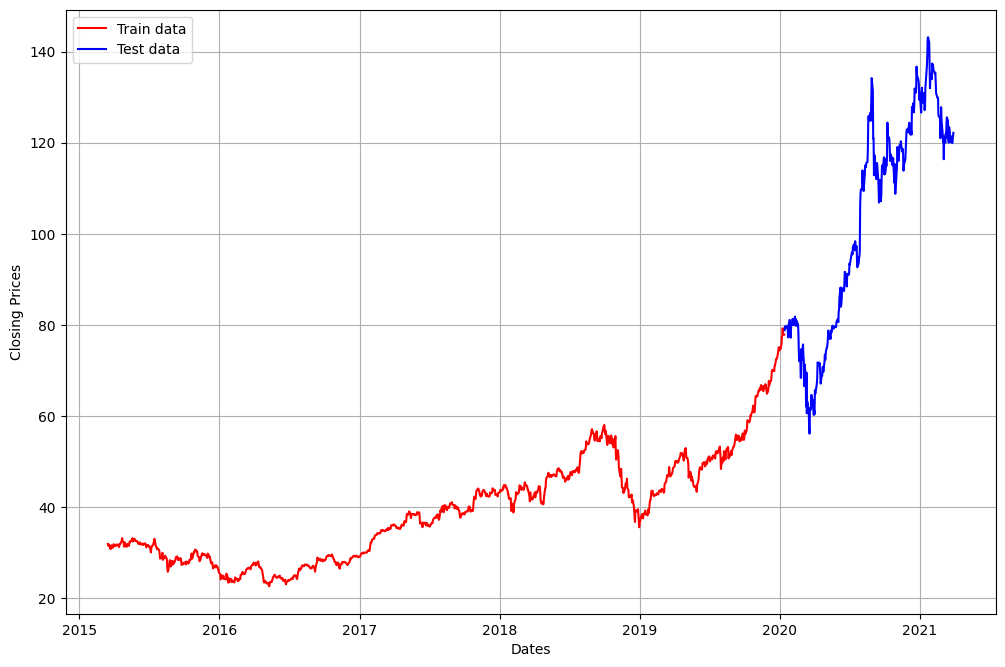

In [ ]:
# Chosing a split of 80% Train and 20% test
train_ind = int(len(df)*0.8)

# Split the initial dataset
train_df = df[:train_ind]
test_df = df[train_ind:]

# Plot the two datasets
plt.figure(figsize=(12,8), dpi=100)
plt.rcParams.update({'font.size': 10})
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

plt.plot(train_df.index, train_df.close.values, 'red', label='Train data')
plt.plot(test_df.index, test_df.close.values, 'blue', label='Test data')

plt.legend()
plt.show()

We notice that the close price has a lot of fluctuations which will make the mission for the model more difficult.

# **Split and Scale**

The following blocs of code concern the spliting and the scaling of the dataset:

- First, we need the function *split()* that will split for us the data into train and test sets with 80-20 percentages.

- Second, we need the function *scale_data()* that will scale the data based on the given scaler. In our case, we used the *MinMaxScaler* provided by scikit-learn.

In [ ]:
def split(full_dataset, features_list):
    """
    This function splits the original dataset into train and test sets.
    
    Arguments:
    - full_dataset: the original dataset.
    - features_list: list of features influencing the target variable.
    
    Returns:
    - Xtrain, ytrain: The training data and its corresponding target values, respectively.
    - Xtest, ytest: The test data and its corresponding target values, respectively.
    """
    # Define the target variable
    y = full_dataset['close'].values.reshape(-1, 1)

    # Selecting features
    X = full_dataset[features_list].values

    # Split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle = False)

    return X_train, y_train, X_test, y_test

In [ ]:
def scale_data(input_scaler, output_scaler, X_train, y_train, X_test):
    """
    This function scales and transforms the train and test sets.

    Arguments: 
    - input_scaler: Scaler for the input data.
    - output_scaler: Scaler for the output data (Target).
    - X_train, y_train: The training data and its corresponding target values, respectively.
    - X_test: The test data.

    Returns: 
    - The train data and its corresponding target values, scaled. 
    - The test data scaled.
    - The scaler fitted on the target test data.
    """

    # Scale X_train and X_test
    input_scaler.fit(X_train)
    X_train = input_scaler.transform(X_train)
    X_test = input_scaler.transform(X_test)
    
    # Scale y_train and y_test
    output_scaler.fit(y_train)
    y_train = output_scaler.transform(y_train)
    
    return X_train, y_train, X_test, output_scaler

**Note:** The *scale_data()* returns the scaler fitted on the train target variable, to save the same "skeleton" of the train target, to inverse the predictions when choosing to scale the dataset.

# **Selected features**

The following blocs of code present the results for different feature selection methods.

In [ ]:
# F1: Most correlated to the target variable
F1 = ['open','high','low','adj_close','sma_indicator5','ema_indicator5','sma_indicator10',
      'ema_indicator10','sma_indicator15','ema_indicator15','sma_indicator20','ema_indicator20',
      'sma_indicator25','ema_indicator25','average_true_range25','sma_indicator30','ema_indicator30',
      'average_true_range30','sma_indicator35','ema_indicator35','average_true_range35',
      'sma_indicator40','ema_indicator40','average_true_range40','sma_indicator45','ema_indicator45',
      'average_true_range45','sma_indicator50','ema_indicator50','average_true_range50','cumulative_return']

# F2: F-regression test
F2 = ['open', 'high', 'low', 'adj_close', 'sma_indicator5', 'ema_indicator5', 'sma_indicator10',
      'ema_indicator10', 'sma_indicator15', 'ema_indicator15', 'sma_indicator20', 'ema_indicator20',
      'ema_indicator25', 'ema_indicator30', 'cumulative_return']

# F3: RandomForestRegressor
F3 = ['open', 'high', 'low', 'adj_close', 'ema_indicator5', 'acc_dist_index', 'cumulative_return']

# F4: Lasso's Regularization
F4 = ['ema_indicator10', 'ema_indicator15', 'ema_indicator20', 'ema_indicator50', 'acc_dist_index']

# F5: Bi-directional elimination(Step-wise Selection)
F5  = ['cumulative_return', 'low', 'open', 'high']

**The following bloc of code gives one of ARIMA's parameters which is the differencing parameter (d).** 

In [ ]:
from pmdarima.arima import ndiffs

adf_diffs = ndiffs(train_df.close, alpha=0.05, test='adf')
print('d =',adf_diffs)

d = 1


**In our case, and using the Augmented Dickey–Fuller test, we got a differencing parameter of 1 day.**

# **Define functions**

**In this section, we will define several functions to tackle the prediction problem.**

In [ ]:
def make_prediction(full_dataset, features_list, use_scale):
    """
    This function makes predicitons based on the features given and the use of scaling.

    Arguments:
    - full_dataset: the original dataset.
    - features_list: list of features influencing the target variable.
    - use_scale: Boolean variable indicating the use of scaling (True: with scaling; False: without scaling)

    Returns:
    - The simple validation predictions, the corresponding confidence interval, and the model used.
    - Predictions using the walk forward, the corresponding confidence interval, and the updated model.
    """

    # Split the data
    X_train, y_train, X_test, y_test = split(full_dataset, features_list)

    if use_scale: ## Make predicitons with scaled data 
        # Define the scaler
        from sklearn.preprocessing import MinMaxScaler
        in_scaler = MinMaxScaler()
        out_scaler = MinMaxScaler()
        
        # Scale the data
        X_train_scaled, y_train_scaled, X_test_scaled, outscaler = scale_data(in_scaler, out_scaler, X_train, y_train, X_test) #!
        
        ### ------ Simple validation ------
        # Fit the model on scaled data
        model_sv = auto_arima(y_train_scaled, X_train_scaled, test = 'adf', max_p = 9, max_q = 9, 
                              trace = True, d = 1, seasonal = True, m = 12, error_action = "ignore")
        # Make predictions
        predictions, conf_int = model_sv.predict(n_periods = len(y_test),
                                    X = pd.DataFrame(data = X_test_scaled, columns = features_list),
                                    return_conf_int = True)

        # Inverse transform the confidence interval
        conf_int0 = outscaler.inverse_transform(conf_int[:, 0].reshape(-1, 1))
        conf_int1 = outscaler.inverse_transform(conf_int[:, 1].reshape(-1, 1))
        conf_int_sv = np.concatenate((conf_int0, conf_int1), axis=1)

        # Inverse transformation for the predictions
        predictions_sv = outscaler.inverse_transform(predictions.reshape(-1, 1))

        ### ------ Walk Forward ------
        predictions_wf = []
        confidence_intervals = []

        # Take a copy of the sv model to save both models when working with mlflow
        from copy import deepcopy
        model_wf = deepcopy(model_sv)

        for idx, new_v in enumerate(y_test):
            # Make predictions
            prediction, conf_int = model_wf.predict(n_periods = 1, 
                                                  X = pd.DataFrame(data = X_test_scaled[idx]).T, 
                                                  return_conf_int = True)

            predictions_wf.append(prediction.tolist()[0])
            confidence_intervals.append(np.asarray(conf_int).tolist()[0])

            model_wf.update([new_v], X = pd.DataFrame(data = X_test_scaled[idx]).T)
        
        conf_int0 = outscaler.inverse_transform(confidence_intervals[:, 0].reshape(-1, 1))
        conf_int1 = outscaler.inverse_transform(confidence_intervals[:, 1].reshape(-1, 1))
        conf_int_sv = np.concatenate((conf_int0, conf_int1), axis=1)

        # Inverse transformation for the predictions
        predictions_wf = outscaler.inverse_transform(predictions_wf.reshape(-1, 1))
        
    else:
        ### ------- Simple validation -------
        # Fit the model on the unscaled data
        model_sv = auto_arima(y_train, X_train, test = 'adf', max_p = 9, max_q = 9, 
                              trace = True, d = 1, seasonal = True, m = 12, error_action = "ignore")
        # Make predictions
        predictions_sv, conf_int_sv = model_sv.predict(n_periods = len(y_test),
                                    X = pd.DataFrame(data = X_test, columns = features_list), 
                                    return_conf_int = True)
        
        ### ------ Walk Forward ------
        predictions_wf = []
        confidence_intervals = []

        # Take a copy of the sv model to save both models when working with mlflow
        import copy
        model_wf = deepcopy(model_sv) 

        for idx, new_v in enumerate(y_test):
            # Make predictions
            predictions, conf_int = model_wf.predict(n_periods = 1, 
                                                  X = pd.DataFrame(data = X_test[idx]).T, 
                                                  return_conf_int = True)

            predictions_wf.append(predictions.tolist()[0])
            confidence_intervals.append(np.asarray(conf_int).tolist()[0])

            model_wf.update([new_v], X = pd.DataFrame(data = X_test[idx]).T)

    return predictions_sv, conf_int_sv, model_sv, predictions_wf, confidence_intervals, model_wf, y_test

In [ ]:
def make_plot(df_test, predictions, conf_int, actual, pred_type):
    """
    This function makes plot for comparing the predictions and the actual close price values.

    Arguments:
    - df_test: test dataset (Needed for the plot index).
    - predictions: Predictions given by the model.
    - conf_int: Confidence interval.
    - actual: Actual close price test values.
    - pred_type: Prediction type, either simple validation ('sv'), or walk forward ('wf')
    """

    df_test.index = df_test.index.astype('datetime64[ns]')
    plt.figure(figsize=(20, 15), dpi=500)
    plt.grid(True)
    plt.title('Stock price forecasting')
    plt.plot(df_test.index, actual, color='red', label='Actual Price')
    plt.plot(df_test.index, predictions, color='green', marker='.',label='Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')

    conf_int = np.asarray(conf_int)
    plt.fill_between(df_test.index, conf_int[:, 0], conf_int[:, 1], 
                    alpha=0.1, color='grey', label="Confidence Interval")
    plt.legend()

    # Save the plot based on the prediciton type
    if pred_type == "wf":
        plt.savefig('fig_wf.png', format='png', dpi=500)
    else:
        plt.savefig('fig_sv.png', format='png', dpi=500)

    plt.show()

In [ ]:
def evaluate(actual, predictions):
  """
  This fuction evaluates the performance of a model by comparing the actual price and the given predictions, according to the following metrics:
  - RMSE: Root Mean Squared Error.
  - MAPE: Mean Absolute Percentage Error.
  - MAE: Mean Absolute Error.

  Arguments:
  - Test data of the target variable, and the predictions made by the model.
  """

  RMSE = mean_squared_error(actual, predictions, squared = False)
  MAPE = mean_absolute_percentage_error(actual, predictions)*100
  MAE = mean_absolute_error(actual, predictions)

  return RMSE, MAE, MAPE

# **Model and parameter testing**

### **Testing the model with F5 set of features**

**with scalling**

In [ ]:
# Get predictions
predictions_sv, conf_int_sv, model_sv, y_test = make_prediction(df, F5, True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-7465.955, Time=2.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-7473.021, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-7469.602, Time=1.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-7469.564, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-7470.698, Time=0.33 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-7471.621, Time=2.85 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-7471.548, Time=1.39 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-7469.316, Time=2.20 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-7471.034, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-7471.034, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-7469.352, Time=1.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 15.770 seconds


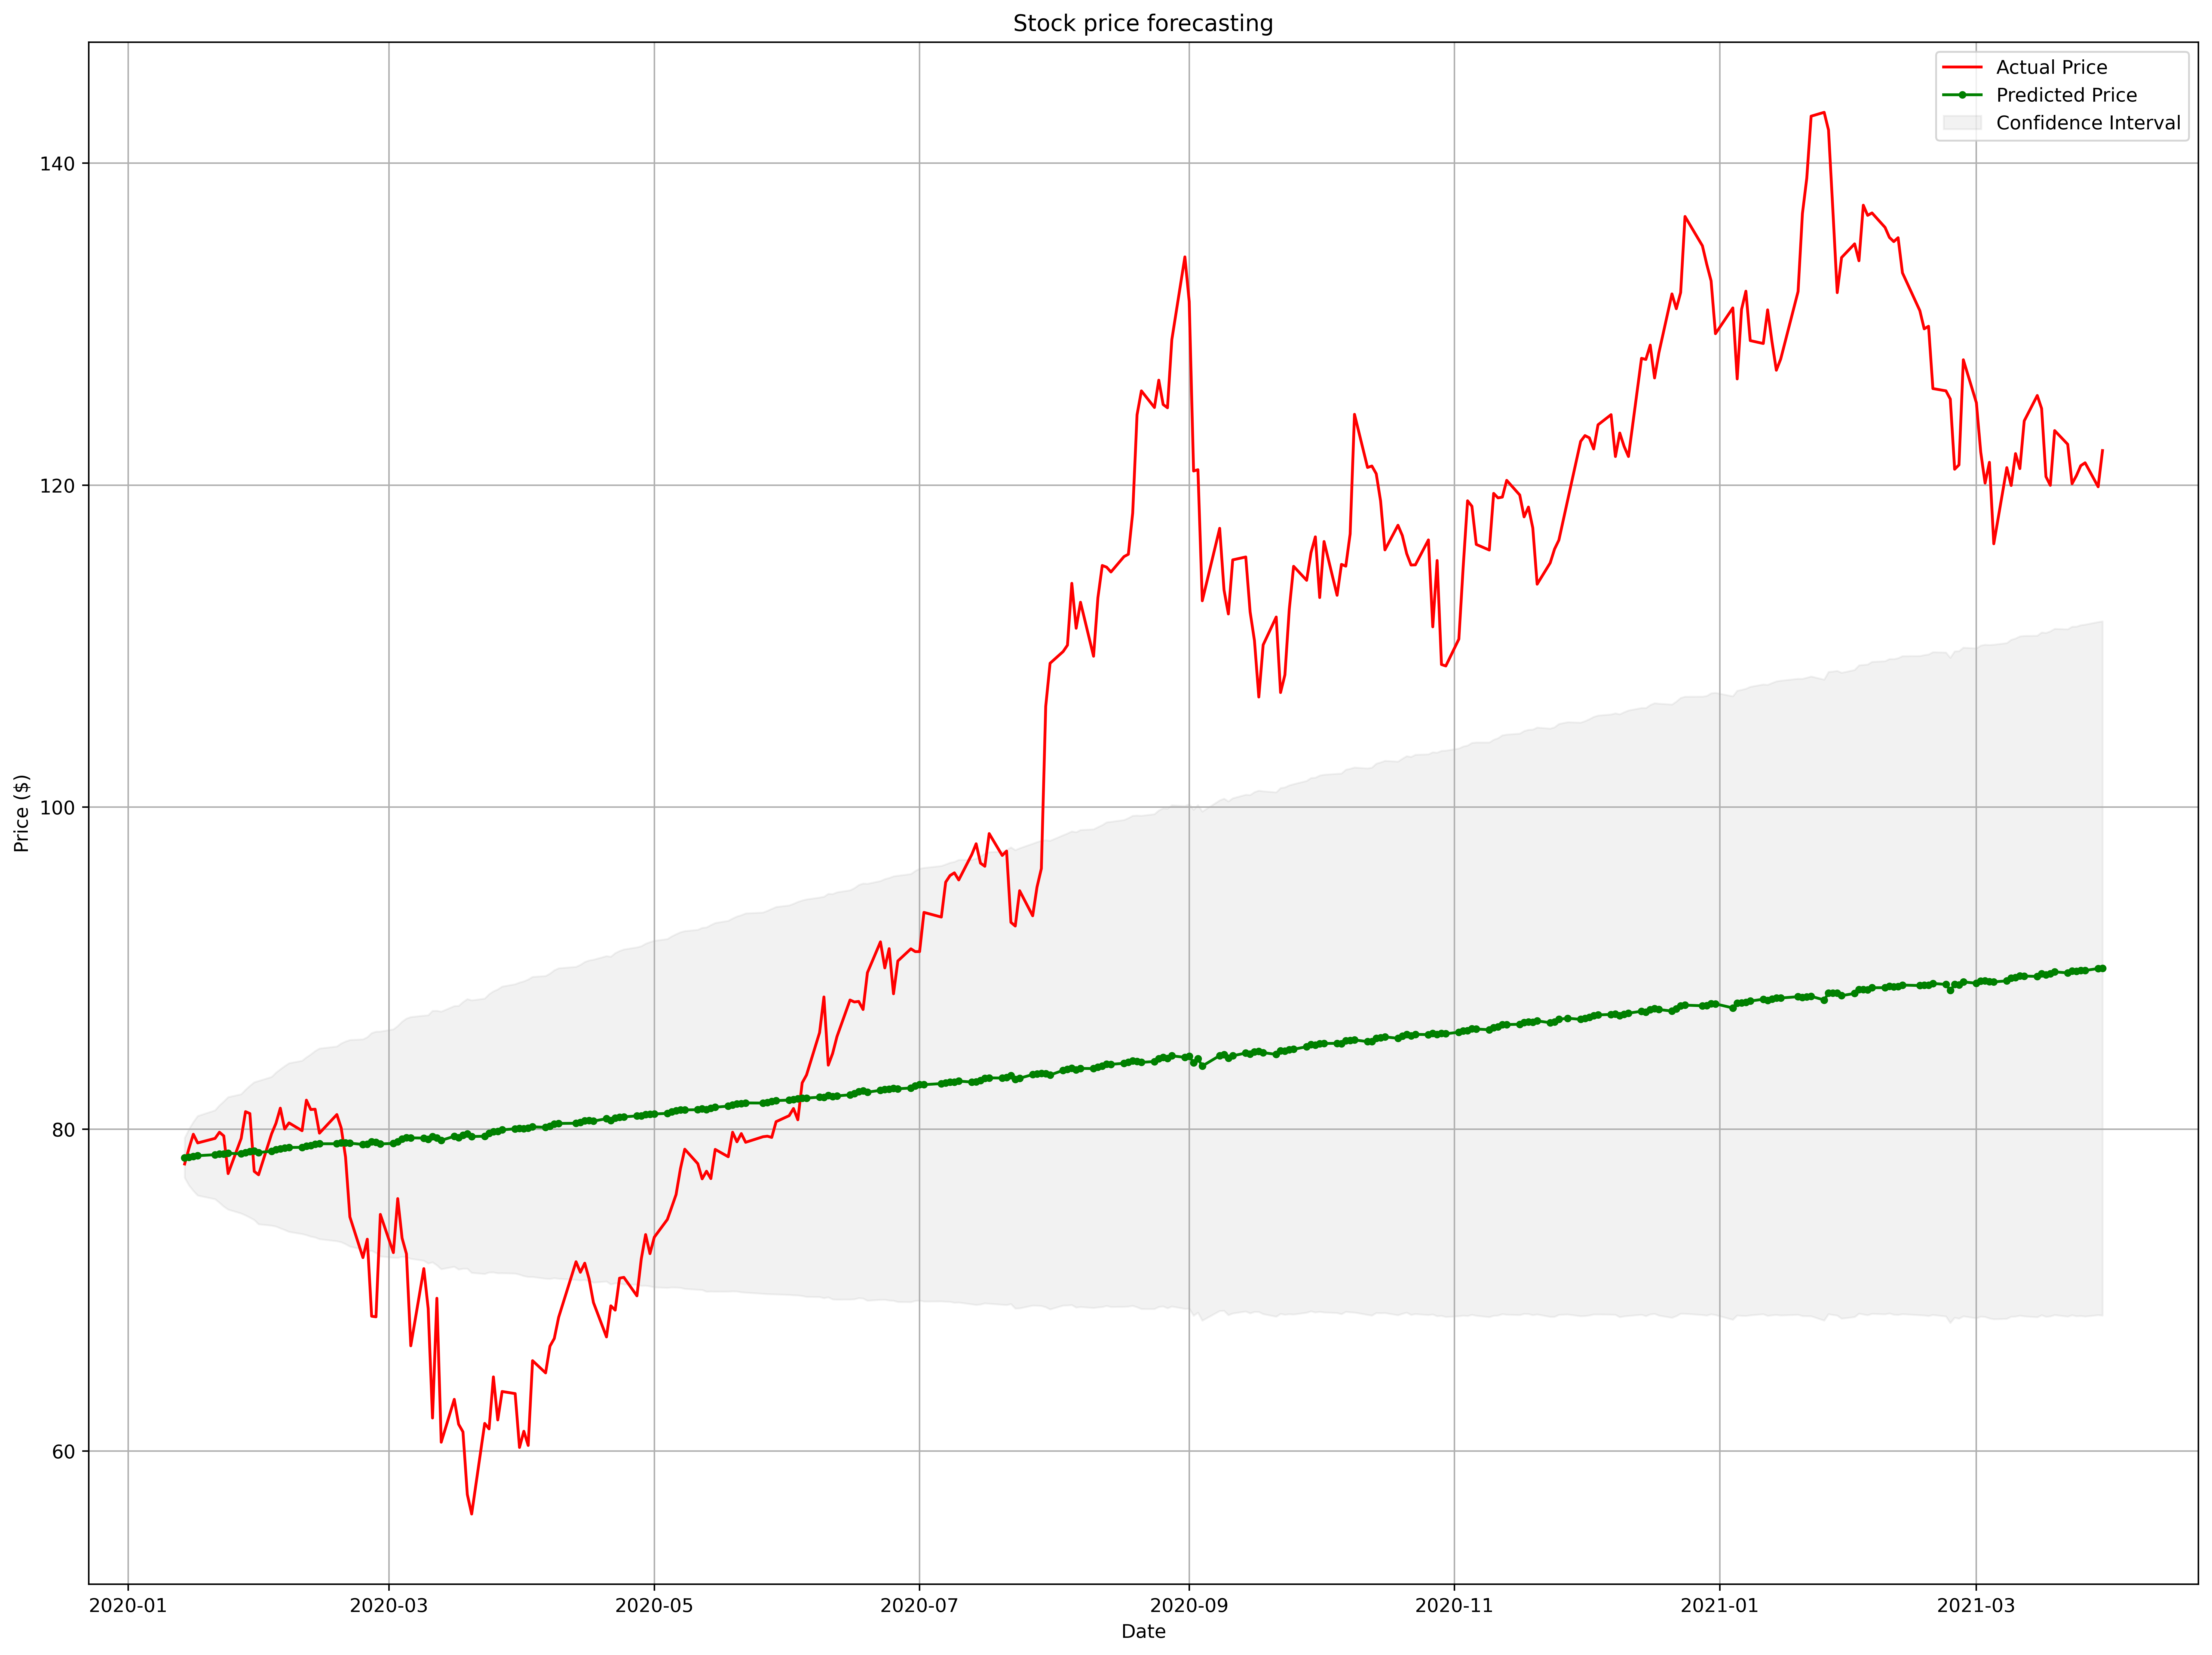

In [ ]:
# Plot results for SV
make_plot(test_df, predictions_sv, conf_int_sv, y_test, "sv")

In [ ]:
# Evaluation for SV
RMSE, MAE, MAPE = evaluate(y_test, predictions_sv)
print('RMSE : ', RMSE,' // MAE : ', MAE,' // MAPE : ', MAPE)

RMSE :  27.566388180820425  // MAE :  22.981789579106458  // MAPE :  20.573716706729254


**Without scalling**

In [ ]:
# Get predictions
predictions_sv, conf_int_sv, model_sv, y_test = make_prediction(df, F5, False)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2335.620, Time=9.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2336.818, Time=0.36 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2340.232, Time=2.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2340.196, Time=4.88 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2339.164, Time=0.38 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2333.620, Time=9.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2331.848, Time=3.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2333.578, Time=10.72 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2338.510, Time=3.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2337.380, Time=3.57 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=2334.064, Time=4.04 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=2333.342, Time=4.35 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2337.551, Time=2.99 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=2331.588, Time=4.11 sec
 ARIMA(1,1,3)(1,0,

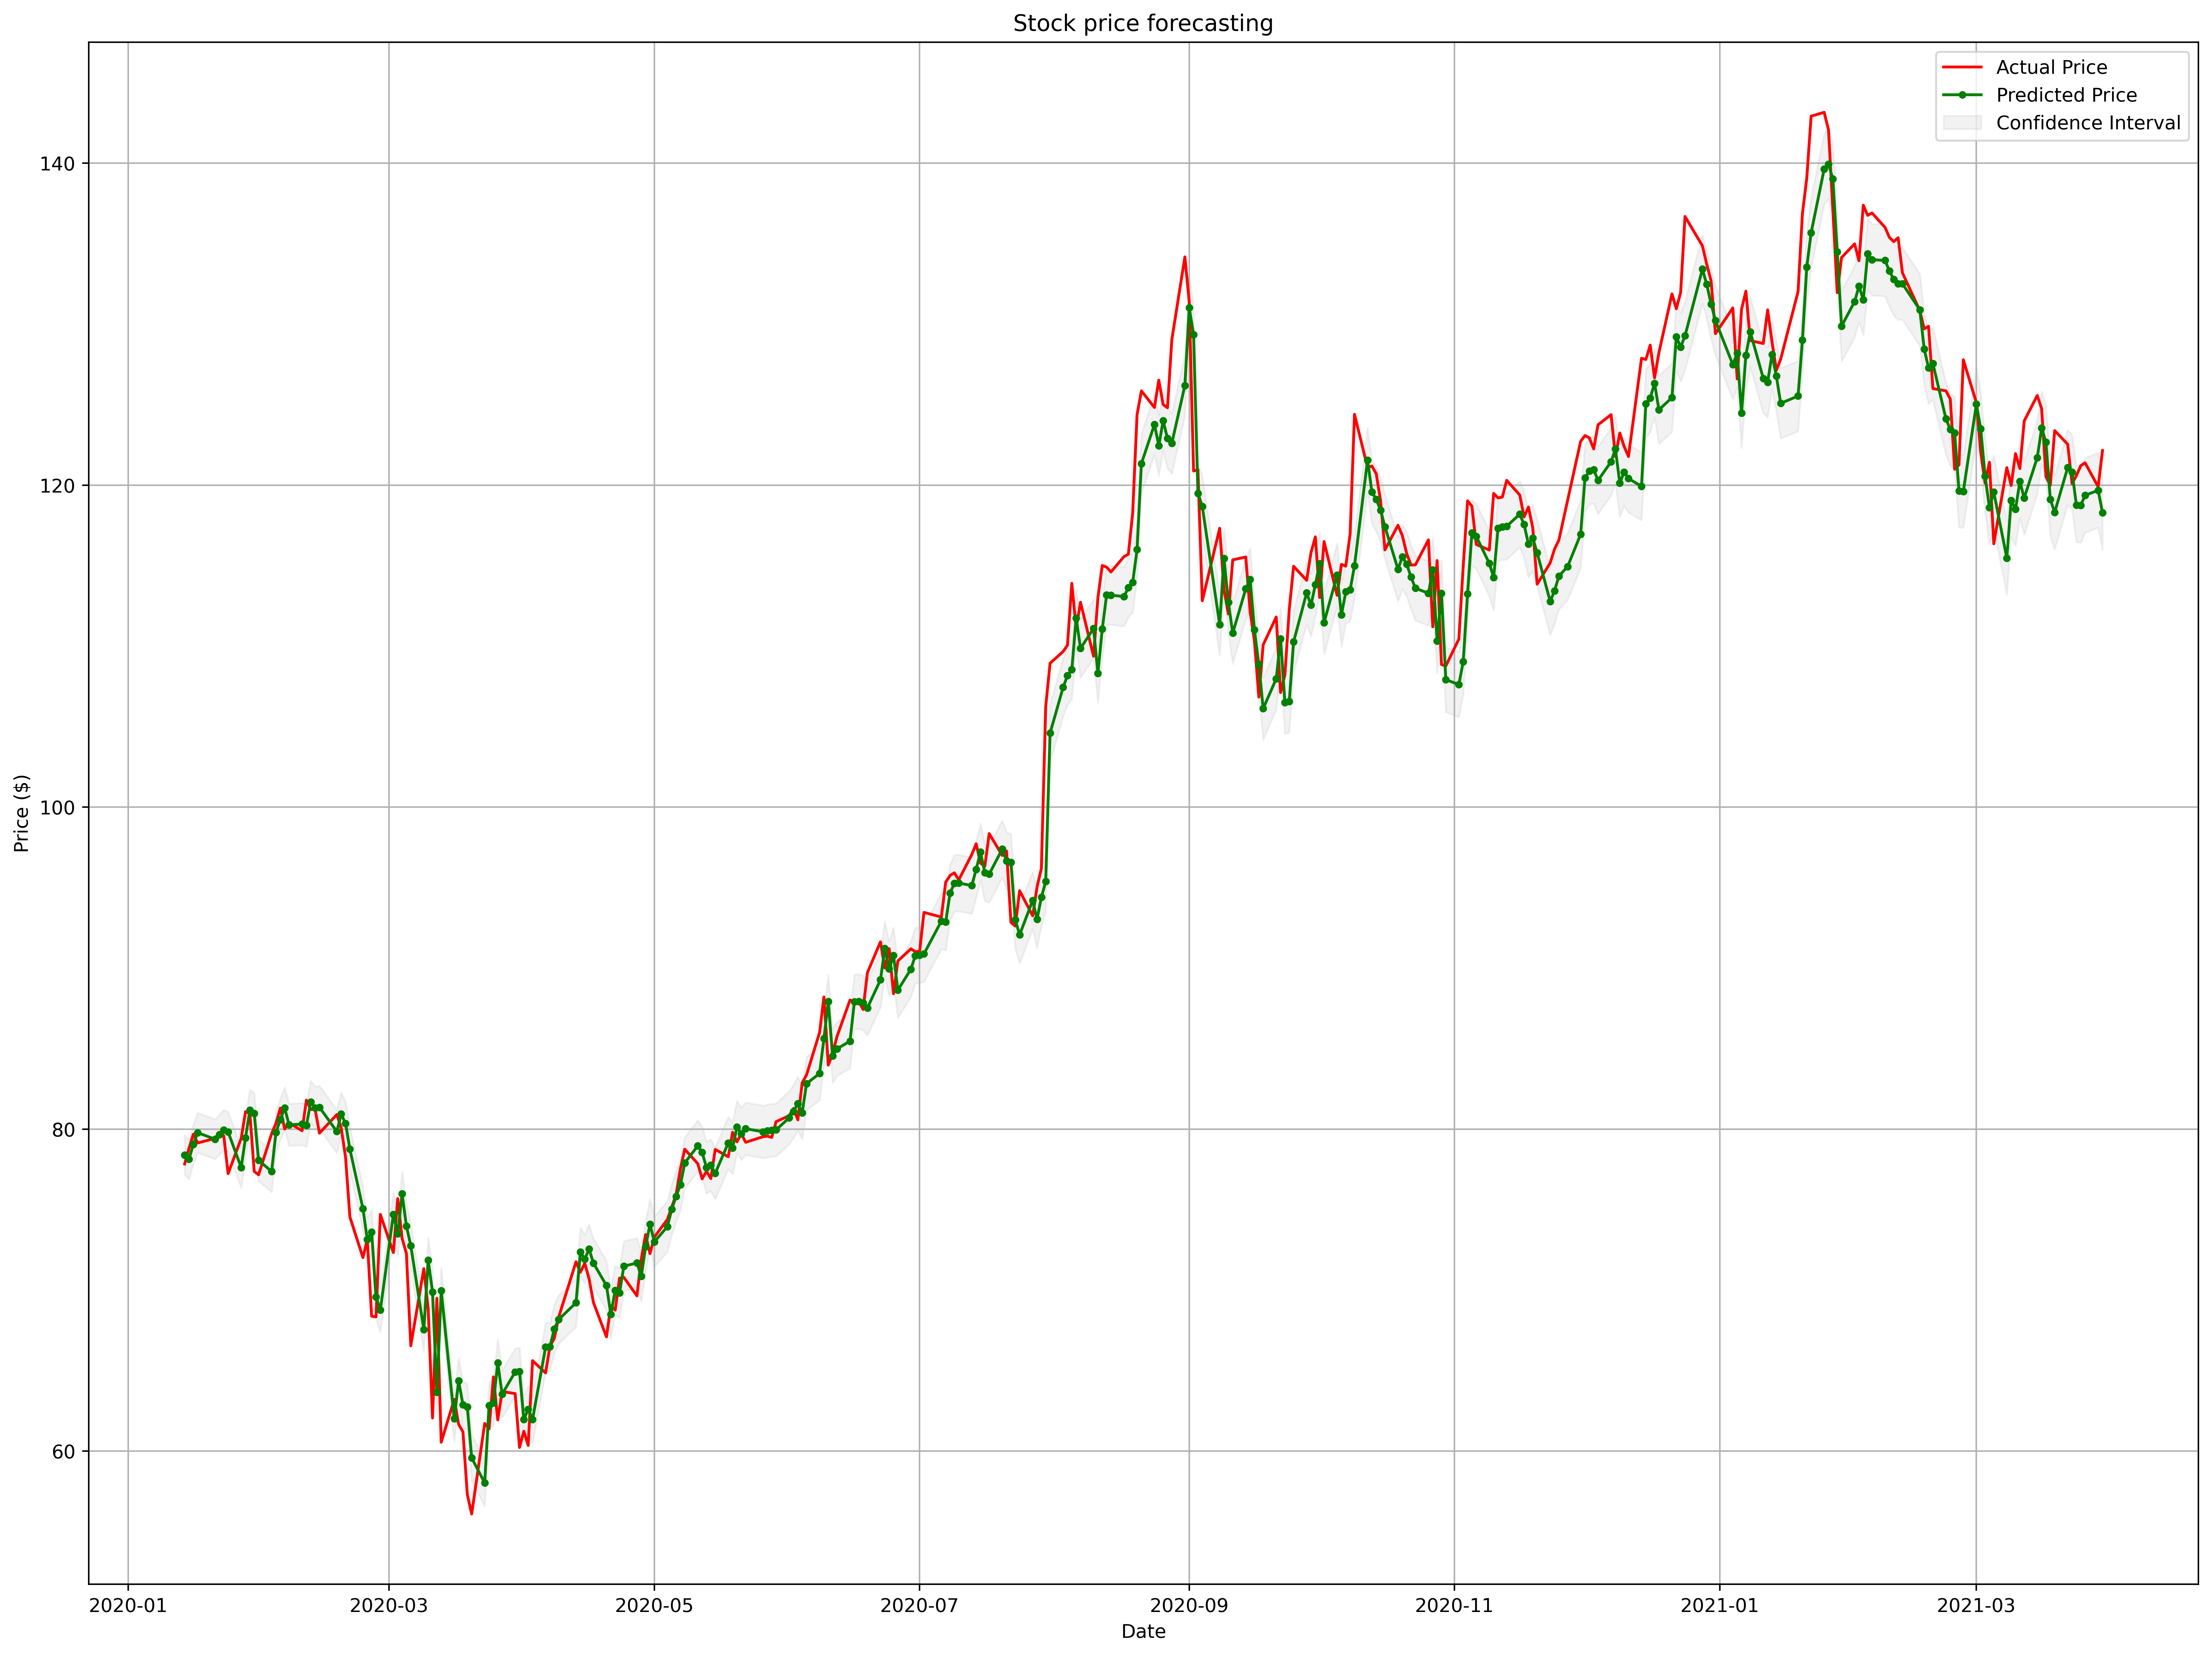

In [ ]:
# Plot results for SV
make_plot(test_df, predictions_sv, conf_int_sv, y_test, "sv")

In [ ]:
# Evaluation for SV
RMSE, MAE, MAPE = evaluate(y_test, predictions_sv)
print('RMSE : ', RMSE,' // MAE : ', MAE,' // MAPE : ', MAPE)

# **MLFLOW saves**

**In this section, we run the Auto-ARIMA model based on different set of features, using the simple validation method, with different cases of scaling.**

In [ ]:
# Prediction type: simple validation "sv"
pred_type = ['sv']

# The use of scaling
use_scale = [False, True]

# Define the set of features in one list
all_feats = [F1, F2, F3, F4, F5]

In [ ]:
for idx, feature in enumerate(all_feats):
    # Spli the data
    X_train, y_train, X_test, y_test = split(df, feature)

    # Start iterating over the use of scaling
    for use in use_scale:
        # Define a name for the model
        model_name = 'auto_arima_f' + str(idx+1) + '_scale_' + str(use)

        # Run mlflow
        with mlflow.start_run(run_name = model_name):
            # Make predictions
            predictions_sv, conf_int_sv, model_sv, y_test = make_prediction(df, feature, use)
            print("\nModel " + model_name + " Completed.\n")
            # Save log parameters
            mlflow.log_param("order", model_sv.get_params()['order'])
            mlflow.log_param("seasonal_order", model_sv.get_params()['seasonal_order'])

            # Save the model's metrics
            mlflow.log_metric("AIC", model_sv.aic())
            mlflow.log_metric("BIC", model_sv.bic())

            # Save the model with simple validation
            mlflow.sklearn.log_model(model_sv, model_name + '_sv')

            # Evaluate the model
            rmse_sv, mae_sv, mape_sv = evaluate(y_test, predictions_sv)
            print('RMSE_sv: ', rmse_sv ,'; MAPE_sv: ', mape_sv ,'; MAE_sv: ', mae_sv)

            # Create a plot for comparison
            print("\n Simple validation Plot:\n")
            make_plot(test_df, predictions_sv, conf_int_sv, y_test, "sv")

            # Save the artifacts: plot and evaluation metrics
            mlflow.log_artifact("fig_sv.png")
            mlflow.log_metric("RMSE_sv", rmse_sv)
            mlflow.log_metric("MAE_sv", mae_sv)
            mlflow.log_metric("MAPE_sv", mape_sv)

        mlflow.end_run()